In [12]:
import xml.etree.ElementTree as ET
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy
import pycountry
from countries_dict import country_to_continent
#import deepcopy
import ColorKit as ck
import matplotlib as mpl
import matplotlib.cm as cm

In [8]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli")

Device set to use cpu


In [3]:
def color_continent_returner(country, color = True):
    countinents = ["Africa", "Asia", "Europe", "North America", "South America", "Oceania"]
    try:
        continent = country_to_continent[country.replace("_", " ")]
    except KeyError:
        result = classifier(country, countinents)
        continent =  (result['labels'][0])

    if color:
        continent_colors = {
        "Africa": "gold",
        "Asia": "red",
        "Europe": "blue",
        "North America": "green",
        "South America": "purple",
        "Oceania": "orange"
        }
        return continent_colors[continent]
    else:
        return continent

In [13]:
def transform_w_to_m_hat(W):
    return np.where(W > 1, 1, np.where(W < -1, -1, W))

def matrix_b(m, variance_k=False):
    matrix = copy.deepcopy(m)

    M_max = np.max(np.abs(matrix))
    if M_max != 0:
        matrix = matrix / M_max

    U, S, Vh = np.linalg.svd(matrix, full_matrices=False)

    n = matrix.shape[0]
    p_hat = 1 


    
    if variance_k:
        sigma_squared = np.var(matrix)  
        q_hat = p_hat * sigma_squared + p_hat * (1 - p_hat) * (1 - sigma_squared)
        threshold = 2.02 * np.sqrt(n * q_hat)
        print(threshold, (2.02 * np.sqrt(n * p_hat)))
        
    else:
        threshold = 2.02 * np.sqrt(n * p_hat)


    S_indices = np.where(S >= threshold)[0]

    
    W = sum(S[i] * np.outer(U[:, i], Vh[i, :]) for i in S_indices)
    matrix = transform_w_to_m_hat(W)

    return matrix

def make_diagonal_0(matrix):
    np.fill_diagonal(matrix, 0)
    return matrix

def plot_heatmap(matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
    plt.title(title)
    plt.show()



In [14]:
def default(name):
    tree = ET.parse(f"{name}.graphml")  
    root = tree.getroot()
    ns = {"graphml": "http://graphml.graphdrawing.org/xmlns"}
    
    
    G = nx.Graph() 
    
    
    for node in root.findall(".//graphml:node", ns):
        node_id = node.attrib["id"]
        
    
        label = node.find(".//graphml:data[@key='key4']", ns)  
        node_label = label.text if label is not None else node_id  
    
        G.add_node(node_id, label=node_label)
    

    for edge in root.findall(".//graphml:edge", ns):
        source = edge.attrib["source"]
        target = edge.attrib["target"]
        G.add_edge(source, target)
    A = nx.adjacency_matrix(G)
    dense_matrix = A.toarray()
    result = matrix_b(dense_matrix, variance_k=True)

    matrix_conversion_for_len = matrix_converter(result)

    degrees_1 = [len(row) for row in dense_matrix]
    degrees_2 = [len(row) for row in matrix_conversion_for_len]

    x = (len(degrees_1)) 

    plt.figure(figsize=(10, 5))
    plt.bar(x, degrees_1,  label="Original Degrees", color="dodgerblue")
    plt.bar(x, degrees_2,  label="Graphon Degrees", color="lightcoral")

    plt.xlabel("Node Index")
    plt.ylabel("Degree (log scale)")
    plt.title("Comparison of Node Degrees: Original vs. Graphon") 
    plt.legend()
    plt.show()

    diff_matrix = dense_matrix - result


    diff_matrix = make_diagonal_0(diff_matrix)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))


    sns.heatmap(dense_matrix, ax=axes[0], cmap="viridis", cbar=True)
    axes[0].set_title(f"Original Adjacency Matrix for {name}")
    
    
    sns.heatmap(result, ax=axes[1], cmap="viridis", cbar=True)
    axes[1].set_title(f"Estimated Graphon Matrixfor {name}")



    
    plt.tight_layout()
    plt.show()

In [35]:
def hex_to_rgb(hex_color):
    """Convert HEX color (AARRGGBB) to RGB tuple (normalized 0-1)."""
    hex_color = hex_color[-6:] 
    return tuple(int(hex_color[i:i+2], 16) / 255 for i in (0, 2, 4))


def get_color_for_brain(name):
    tree = ET.parse(f"{name}.graphml")  
    root = tree.getroot()
    ns = {"graphml": "http://graphml.graphdrawing.org/xmlns"}
    
    G = nx.Graph()
    node_colors = [] 
    
    for node in root.findall(".//graphml:node", ns):
        node_id = node.attrib["id"]
        
        color_data = node.find(".//graphml:data[@key='key2']", ns)  
        color = hex_to_rgb(color_data.text) if color_data is not None else (0, 0, 0)  
        
        G.add_node(node_id)
        node_colors.append(color)  
    
    for edge in root.findall(".//graphml:edge", ns):
        source = edge.attrib["source"]
        target = edge.attrib["target"]
        G.add_edge(source, target)


    A = nx.adjacency_matrix(G)
    dense_matrix = A.toarray()
    result = matrix_b(dense_matrix, variance_k=True)


    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    sns.heatmap(dense_matrix, ax=axes[0], cmap=our_cmap, cbar=True, xticklabels=False, yticklabels=False, zorder = 10)
    axes[0].set_title(f"Original Adjacency Matrix for {name}")


 
    for i, color in enumerate(node_colors):
        axes[0].hlines(i, *axes[0].get_xlim(), color=color, linewidth=2, zorder=0)
        axes[0].vlines(i, *axes[0].get_ylim(), color=color, linewidth=2, zorder=0)
        axes[1].hlines(i, *axes[1].get_xlim(), color=color, linewidth=2, zorder = 0)
        axes[1].vlines(i, *axes[1].get_ylim(), color=color, linewidth=2, zorder = 0)

    sns.heatmap(result, ax=axes[1], cmap=our_cmap, cbar=True, xticklabels=False, yticklabels=False, zorder= 10)
    axes[1].set_title(f"Estimated Graphon Matrix for {name}")


    plt.tight_layout()
    plt.show()

    return dense_matrix, result




In [18]:
def parse_graphml(name):
    tree = ET.parse(f"{name}.graphml")
    root = tree.getroot()
    ns = {"graphml": "http://graphml.graphdrawing.org/xmlns"}

    G = nx.Graph()
    node_labels = {}

    for node in root.findall(".//graphml:node", ns):
        node_id = node.attrib["id"]
        label = node.find(".//graphml:data[@key='key5']", ns)  
        node_label = label.text if label is not None else node_id  
        node_labels[node_id] = node_label
        G.add_node(node_id, label=node_label)

    for edge in root.findall(".//graphml:edge", ns):
        source = edge.attrib["source"]
        target = edge.attrib["target"]
        G.add_edge(source, target)

    return G, node_labels

def colorbar_from_continent(labels):
    """Creates a color bar for the heatmap based on continents."""
    colors = [color_continent_returner(labels[node]) for node in labels]
    return colors


def reorder_matrix_2(G, labels):
    """Reorders the adjacency matrix so that countries from the same continent are grouped together."""
    node_list = list(G.nodes)

    sorted_nodes = sorted(node_list, key=lambda node: color_continent_returner(labels[node], color=False))

    A = nx.adjacency_matrix(G, nodelist=sorted_nodes)
    dense_matrix = A.toarray()

    new_labels = {i: labels[node] for i, node in enumerate(sorted_nodes)}

    return dense_matrix, new_labels, sorted_nodes


def plot_matrices(G, labels, name):
    dense_matrix, new_labels, sorted_nodes = reorder_matrix_2(G, labels)

    result = matrix_b(dense_matrix, variance_k=True)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    colors = colorbar_from_continent(new_labels)


    sns.heatmap(dense_matrix, ax=axes[0], cmap=our_cmap, cbar=True, xticklabels=False, yticklabels=False, zorder = 10)
    for i, color in enumerate(colors):
        axes[0].hlines(i, *axes[0].get_xlim(), color=color_to_hx_w_alpha(color,1), linewidth=2, zorder=0)
        axes[0].vlines(i, *axes[0].get_ylim(), color=color_to_hx_w_alpha(color,1), linewidth=2, zorder=0)
        axes[1].hlines(i, *axes[1].get_xlim(), color=color_to_hx_w_alpha(color,1), linewidth=2, zorder = 0)
        axes[1].vlines(i, *axes[1].get_ylim(), color=color_to_hx_w_alpha(color,1), linewidth=2, zorder = 0)

    axes[0].set_title(f"Reordered Adjacency Matrix for {name}")

    sns.heatmap(result, ax=axes[1], cmap=our_cmap, cbar=True, xticklabels=False, yticklabels=False, zorder= 10)
    axes[1].set_title(f"Estimated Graphon Matrix for {name}")


    plt.tight_layout()
    plt.show()

def color_to_hx_w_alpha(color, alpha):
    value = (ck.Color(color).rgb())
    s = (list([i/255 for i in value]))
    s.append(alpha)
    st = (tuple(s))

    hex_v = mpl.colors.rgb2hex(st)
    
    return hex_v

cdict = {'red':   [(0.0,  1.0, 1.0),
                   (1.0,  1.0, 1.0)],

         'green':  [(0.0,  1.0, 1.0),
                   (1.0,  1.0, 1.0)],

         'blue':  [(0.0,  1.0, 1.0),
                   (1.0,  1.0, 1.0)], 
         'alpha': [(0.0,  0.0, 0.0),
                   (1.0,  1.0, 1.0)],
        }

def for_dense_check(G, labels, name):
    dense_matrix, new_labels, sorted_nodes = reorder_matrix_2(G, labels)

    result = matrix_b(dense_matrix, variance_k=True)
    return dense_matrix, result



In [41]:

cdict = {
    'red':   [(0.0, 1.0, 1.0),
              (1.0, 1.0, 1.0)],
    'green': [(0.0, 1.0, 1.0),
              (1.0, 1.0, 1.0)],
    'blue':  [(0.0, 1.0, 1.0),
              (1.0, 1.0, 1.0)],
    'alpha': [(0.0, 1.0, 1.0),   
              (1.0, 0.0, 0.0)],  
}


our_cmap = matplotlib.colors.LinearSegmentedColormap('ourmap_2', segmentdata=cdict)



In [20]:
G, labels = parse_graphml("fao_trade")
dense, result = for_dense_check(G, labels, 'fao')

14.543587792930422 29.550052453422143


In [22]:
dense_matrix = []
result_matrix = []

for i in dense:
    dense_matrix.append(sum(i) / len(i))
for v in result:
    result_matrix.append(sum(i)/ len(i))

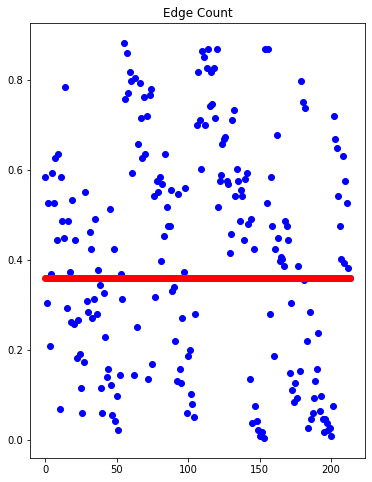

In [34]:
plt.figure(figsize=(6,8))
plt.scatter(range(len(dense_matrix)), dense_matrix, color = 'blue')
plt.scatter(range(len(result_matrix)), result_matrix, color = 'red')
plt.title('Edge Count')
plt.show()


In [ ]:
#degree is bad, #is robust tho, before and after application of fao_trade

9.522648654434995 28.921998547818234


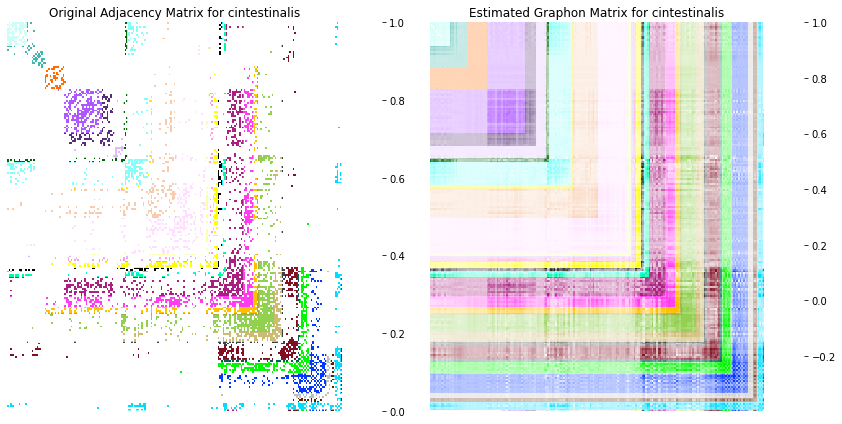

In [42]:
dense, result = get_color_for_brain("cintestinalis")

In [43]:
dense_matrix = []
result_matrix = []

for i in dense:
    dense_matrix.append(sum(i) / len(i))
for v in result:
    result_matrix.append(sum(i)/ len(i))

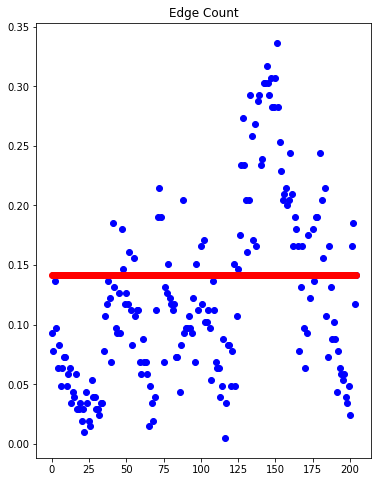

In [44]:
plt.figure(figsize=(6,8))
plt.scatter(range(len(dense_matrix)), dense_matrix, color = 'blue')
plt.scatter(range(len(result_matrix)), result_matrix, color = 'red')
plt.title('Edge Count')
plt.show()


In [24]:
stuff = ['jazz_collab',  "cintestinalis", 'fao_trade']

In [25]:
for s in stuff:
    default(s)

9.859300193151176 28.423919504529984


NameError: name 'deepcopy' is not defined